### Boosting - adaboost

Las técnicas de boosting se basan en la estimación de modelos de manera secuencial para corregir los errores de os anteriories, estimádolos sobre la misma muestra (sin remuestreo) pero sobreponderando las observaciones en las que el modelo anterior cometía errores, para corregir esas predicciones.

Los árboles iterados, gradient boosting, adapting boosting o árboles adaboost son árboles de decisión que se van iterando sobreponderando los registors en los que el árbol anterior cometía un error mayor, para corregir ese error en los entrenamientos de árboles sucesivos. Además, se utilizar una pnealización (shrinkage) para que el aprendizaje sea lento y no se sobreajuste el modelo (es decir, para que las observaciones en las que se cometen errores se sobreponderen un poco más o mucho más en iteraciones posteriores). El modelo final será similar a un random forest ( se combinan los resultados de todos los árboles), pero calculando la media ponderada (por el error) de cada uno de los modelos construidos.

Algunas implementaciones permiten controlar directamente la profunidad de los árboles, mientras que otros controlan el número total de nodos o el número mínimo de observaciones en nodos finales. Se van a probar distintos valores para la velocidad de aprendizaje o shrinkage (o.5, 0.2, 0.1, 0.05, 0.01, 0.001). El resto de parametrizaciones se van a dear en: 100 árboles y sólo 6 (raíz del número de variables candidatas totales) variables candidatas por árbol.

Ventajas:

* Sobreajustan menos que los árboles o random forest

Restricciones:

* Requieren de más tiempo de ejecución (en un random forest los distintos modelos se pueden estimular en paralelo)

Parámetros:

* n_estimadors: número de árboles
* learning_rate: velocidad de aprendizaje
* max_depth: profundidad máxima
* min_samples_split: mínimo tamaño de un nodo para partirlo
* min_samples:leaf: mínimo tamaño de una nueva hoja/partición
* max_features: número variables consideradas para partir un nodo ("sqrt")

La implementación que vamos a utilizar no permite trabajar directamente co missings ni con variables categóricas.

In [2]:
# Importar Paquetes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc

In [5]:
# Carga de datos 
titanic = pd.read_csv("C:/Users/pauri/OneDrive/Escritorio/Python projects/CUA Big Data/titanic (1).csv")
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
titanic.set_index("PassengerId",inplace=True)

Estudiamos si existen valores missing

In [14]:
titanic.isnull().sum()/titanic.shape[0]

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

El 20% de la vaiable Age y el 77% de la variable Cabin vienen missing. La variable Cabin la eliminaemos, pues hay muchos missing values. Para la variable Embaked los sustituimos por el valor mas repetido.El 20% de la vaiable Age y el 77% de la variable Cabin vienen missing. La variable Cabin la eliminaemos, pues hay muchos missing values. Para la variable Embaked los sustituimos por el valor mas repetido.

<Axes: title={'center': 'Age'}, xlabel='[Pclass]'>

<Figure size 2000x1000 with 0 Axes>

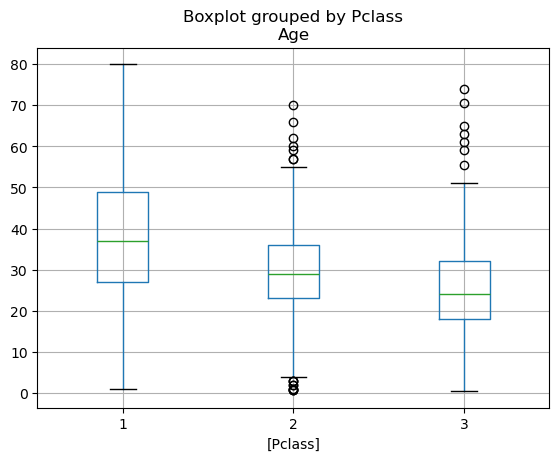

In [25]:
# Para la variable Age, sustituiremos los valores missing cruzandola con otra vairable categórica, como PClass

plt.figure(figsize=(20,10))
titanic[["Age","Pclass"]].boxplot(by="Pclass")

In [28]:
# Sustutiumos la variable missing por age 38, 29 o 24 en función de si Pclass es 1, 2 o 3.

def imputar_edad (cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        if Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [31]:
titanic["Age"] = titanic[["Age","Pclass"]].apply(imputar_edad,axis=1)

C:\Users\pauri\AppData\Local\Temp\ipykernel_23956\715590607.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
C:\Users\pauri\AppData\Local\Temp\ipykernel_23956\715590607.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


In [34]:
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [37]:
# Eliminamos vaiable cabin y los missing values de Embarked

titanic.drop("Cabin",axis=1,inplace=True)
titanic.dropna(inplace=True)
titanic.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [40]:
# Transformación variables categóricas

sex = pd.get_dummies(titanic["Sex"],drop_first=True).astype(int)
embarked = pd.get_dummies(titanic["Embarked"],drop_first=True).astype(int)

In [43]:
# Eliminamos la variable Ticket por ser identificador del pasaejro y la variable nombre

titanic.drop(["Sex","Embarked","Name","Ticket"],axis=1,inplace=True)
titanic = pd.concat([titanic,sex,embarked],axis=1)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


#### Preparación entrada modelo

In [48]:
X = titanic.drop("Survived",axis=1)
y = titanic["Survived"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123456789)

#### Estimación del adaboost

Por defecto, este algoritmo utiliza árboles con profunidad máxima 1. Si se quieren emplear otro tipo de árboles, es necesario indicarlo mediante el parámetro "estimator".

In [56]:
adaboost = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1)

adaboost.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

In [58]:
estimador_base = DecisionTreeClassifier(max_depth = 5, random_state=123456789, max_features= "sqrt")

In [60]:
adaboost_1 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, estimator = estimador_base)

adaboost_1.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    max_features='sqrt',
                                                    random_state=123456789),
                   learning_rate=0.1, n_estimators=100)

#### Clasificación con el adaboost

Podemos obtener las predicciones como probabilidades o clases estimadas.

In [63]:
test_prediccion_1 = adaboost_1.predict(X_test)
test_prediccion_1

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0], dtype=int64)

In [65]:
test_predict_prob_1 = adaboost_1.predict_proba(X_test)
test_predict_prob_1

array([[6.95278532e-01, 3.04721468e-01],
       [7.30387579e-01, 2.69612421e-01],
       [4.66760297e-01, 5.33239703e-01],
       [7.01561432e-01, 2.98438568e-01],
       [3.68657524e-01, 6.31342476e-01],
       [7.22391281e-01, 2.77608719e-01],
       [1.23033834e-01, 8.76966166e-01],
       [9.82300202e-01, 1.76997977e-02],
       [6.78355303e-01, 3.21644697e-01],
       [8.78809651e-01, 1.21190349e-01],
       [8.32348287e-01, 1.67651713e-01],
       [6.78006431e-01, 3.21993569e-01],
       [8.30279324e-01, 1.69720676e-01],
       [8.10967962e-01, 1.89032038e-01],
       [9.26333816e-01, 7.36661840e-02],
       [9.26628114e-01, 7.33718858e-02],
       [6.02863210e-01, 3.97136790e-01],
       [2.42713192e-01, 7.57286808e-01],
       [9.90287091e-02, 9.00971291e-01],
       [2.31806045e-01, 7.68193955e-01],
       [8.21860805e-01, 1.78139195e-01],
       [3.33676789e-01, 6.66323211e-01],
       [1.01358174e-02, 9.89864183e-01],
       [2.61200005e-01, 7.38799995e-01],
       [1.204327

 #### Visualización o interpretación del adaboost
 
La estructura del adaboost similar a la de un árbol de decisión (sentencias condicionales, se asgina la probabilidad del nodo en el que cae la observación que se evalúa), pero ponderando los <b>n</b> árboles incluidos en el adaboost (100 en el caso anterior).
    
La visualización de los 100 árboles es compleja y no aporta mucho valor, porque cada uno de ellos tiene poco peso en la decisión final.

In [69]:
# Guardamos los dos primerso árbols de random forest

tree_1 = adaboost_1.estimators_[1]
tree_2 = adaboost_1.estimators_[2]


[Text(0.509375, 0.9166666666666666, 'Pclass <= 2.5\ngini = 0.459\nsamples = 622\nvalue = [0.643, 0.357]'),
 Text(0.2375, 0.75, 'SibSp <= 0.5\ngini = 0.499\nsamples = 278\nvalue = [0.225, 0.208]'),
 Text(0.075, 0.5833333333333334, 'Fare <= 7.75\ngini = 0.473\nsamples = 176\nvalue = [0.165, 0.103]'),
 Text(0.05, 0.4166666666666667, 'gini = 0.0\nsamples = 8\nvalue = [0.014, 0.0]'),
 Text(0.1, 0.4166666666666667, 'Parch <= 0.5\ngini = 0.482\nsamples = 168\nvalue = [0.151, 0.103]'),
 Text(0.05, 0.25, 'male <= 0.5\ngini = 0.473\nsamples = 137\nvalue = [0.138, 0.086]'),
 Text(0.025, 0.08333333333333333, 'gini = 0.195\nsamples = 41\nvalue = [0.005, 0.044]'),
 Text(0.075, 0.08333333333333333, 'gini = 0.366\nsamples = 96\nvalue = [0.133, 0.042]'),
 Text(0.15, 0.25, 'Age <= 52.0\ngini = 0.488\nsamples = 31\nvalue = [0.013, 0.017]'),
 Text(0.125, 0.08333333333333333, 'gini = 0.454\nsamples = 28\nvalue = [0.009, 0.017]'),
 Text(0.175, 0.08333333333333333, 'gini = 0.145\nsamples = 3\nvalue = [0.004,

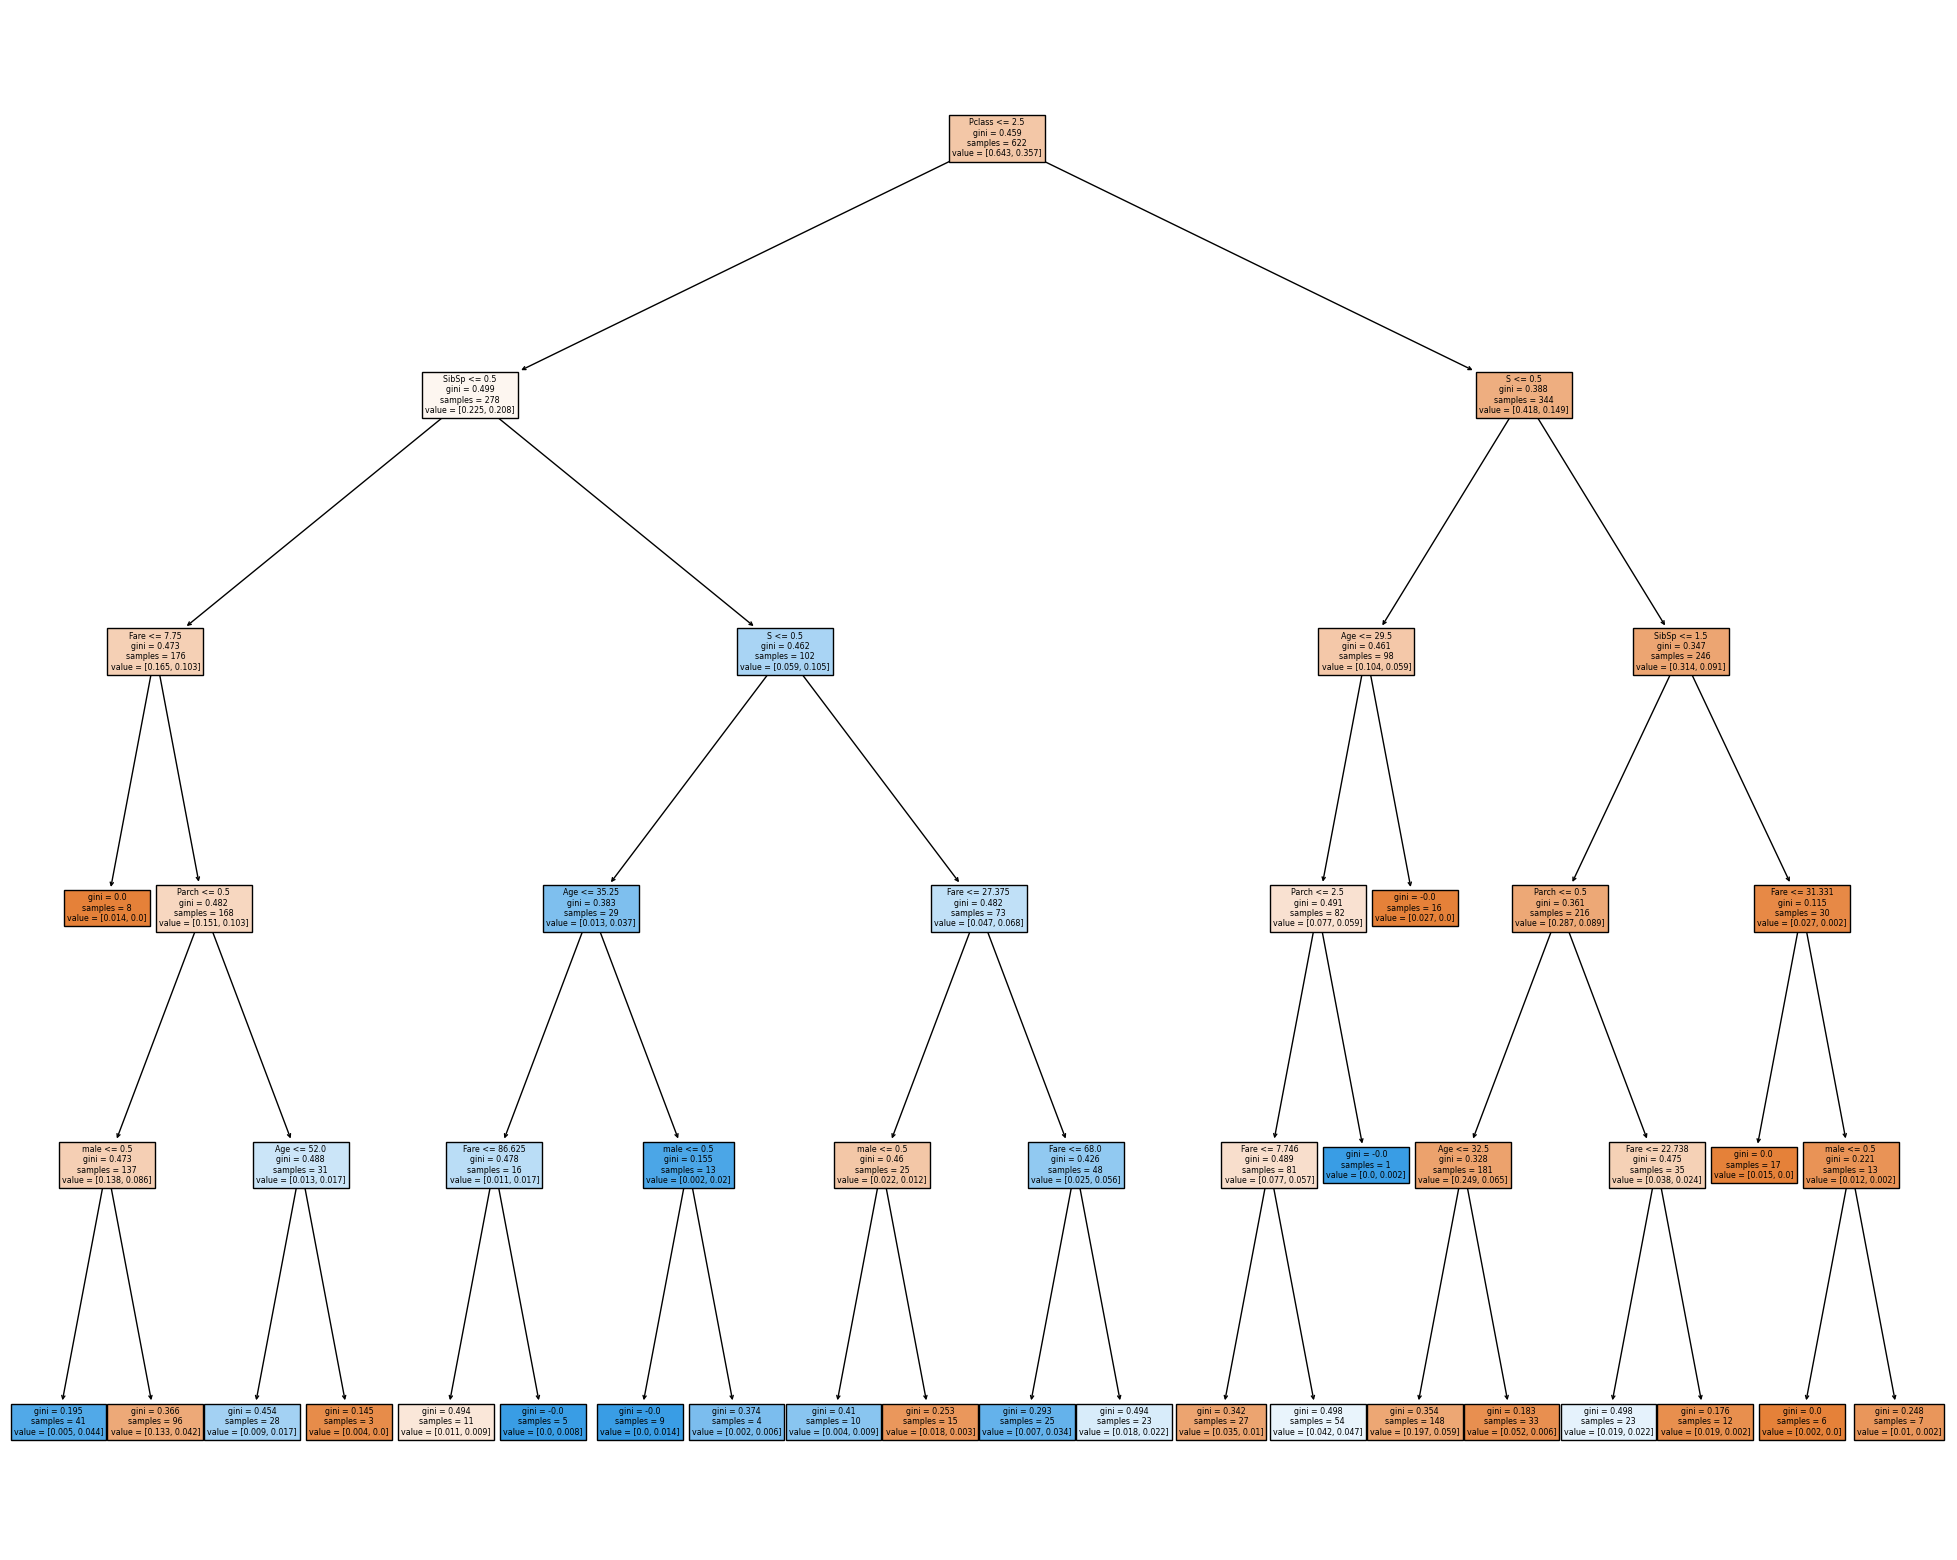

In [73]:
# Visualización del primero

fig = plt.figure(figsize=(25,20))

tree.plot_tree(tree_1,feature_names=["Pclass","Age","SibSp","Parch","Fare","male","Q","S"], filled=True)

[Text(0.4236111111111111, 0.9166666666666666, 'S <= 0.5\ngini = 0.468\nsamples = 622\nvalue = [0.627, 0.373]'),
 Text(0.1527777777777778, 0.75, 'Age <= 17.5\ngini = 0.496\nsamples = 165\nvalue = [0.131, 0.109]'),
 Text(0.05555555555555555, 0.5833333333333334, 'Pclass <= 2.5\ngini = 0.455\nsamples = 21\nvalue = [0.009, 0.017]'),
 Text(0.027777777777777776, 0.4166666666666667, 'gini = 0.0\nsamples = 6\nvalue = [0.0, 0.006]'),
 Text(0.08333333333333333, 0.4166666666666667, 'Age <= 16.5\ngini = 0.497\nsamples = 15\nvalue = [0.009, 0.011]'),
 Text(0.05555555555555555, 0.25, 'Fare <= 16.621\ngini = 0.48\nsamples = 14\nvalue = [0.007, 0.011]'),
 Text(0.027777777777777776, 0.08333333333333333, 'gini = 0.396\nsamples = 9\nvalue = [0.004, 0.011]'),
 Text(0.08333333333333333, 0.08333333333333333, 'gini = 0.0\nsamples = 5\nvalue = [0.003, 0.0]'),
 Text(0.1111111111111111, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0.002, 0.0]'),
 Text(0.25, 0.5833333333333334, 'Fare <= 15.148\ngini = 0.49\nsamples =

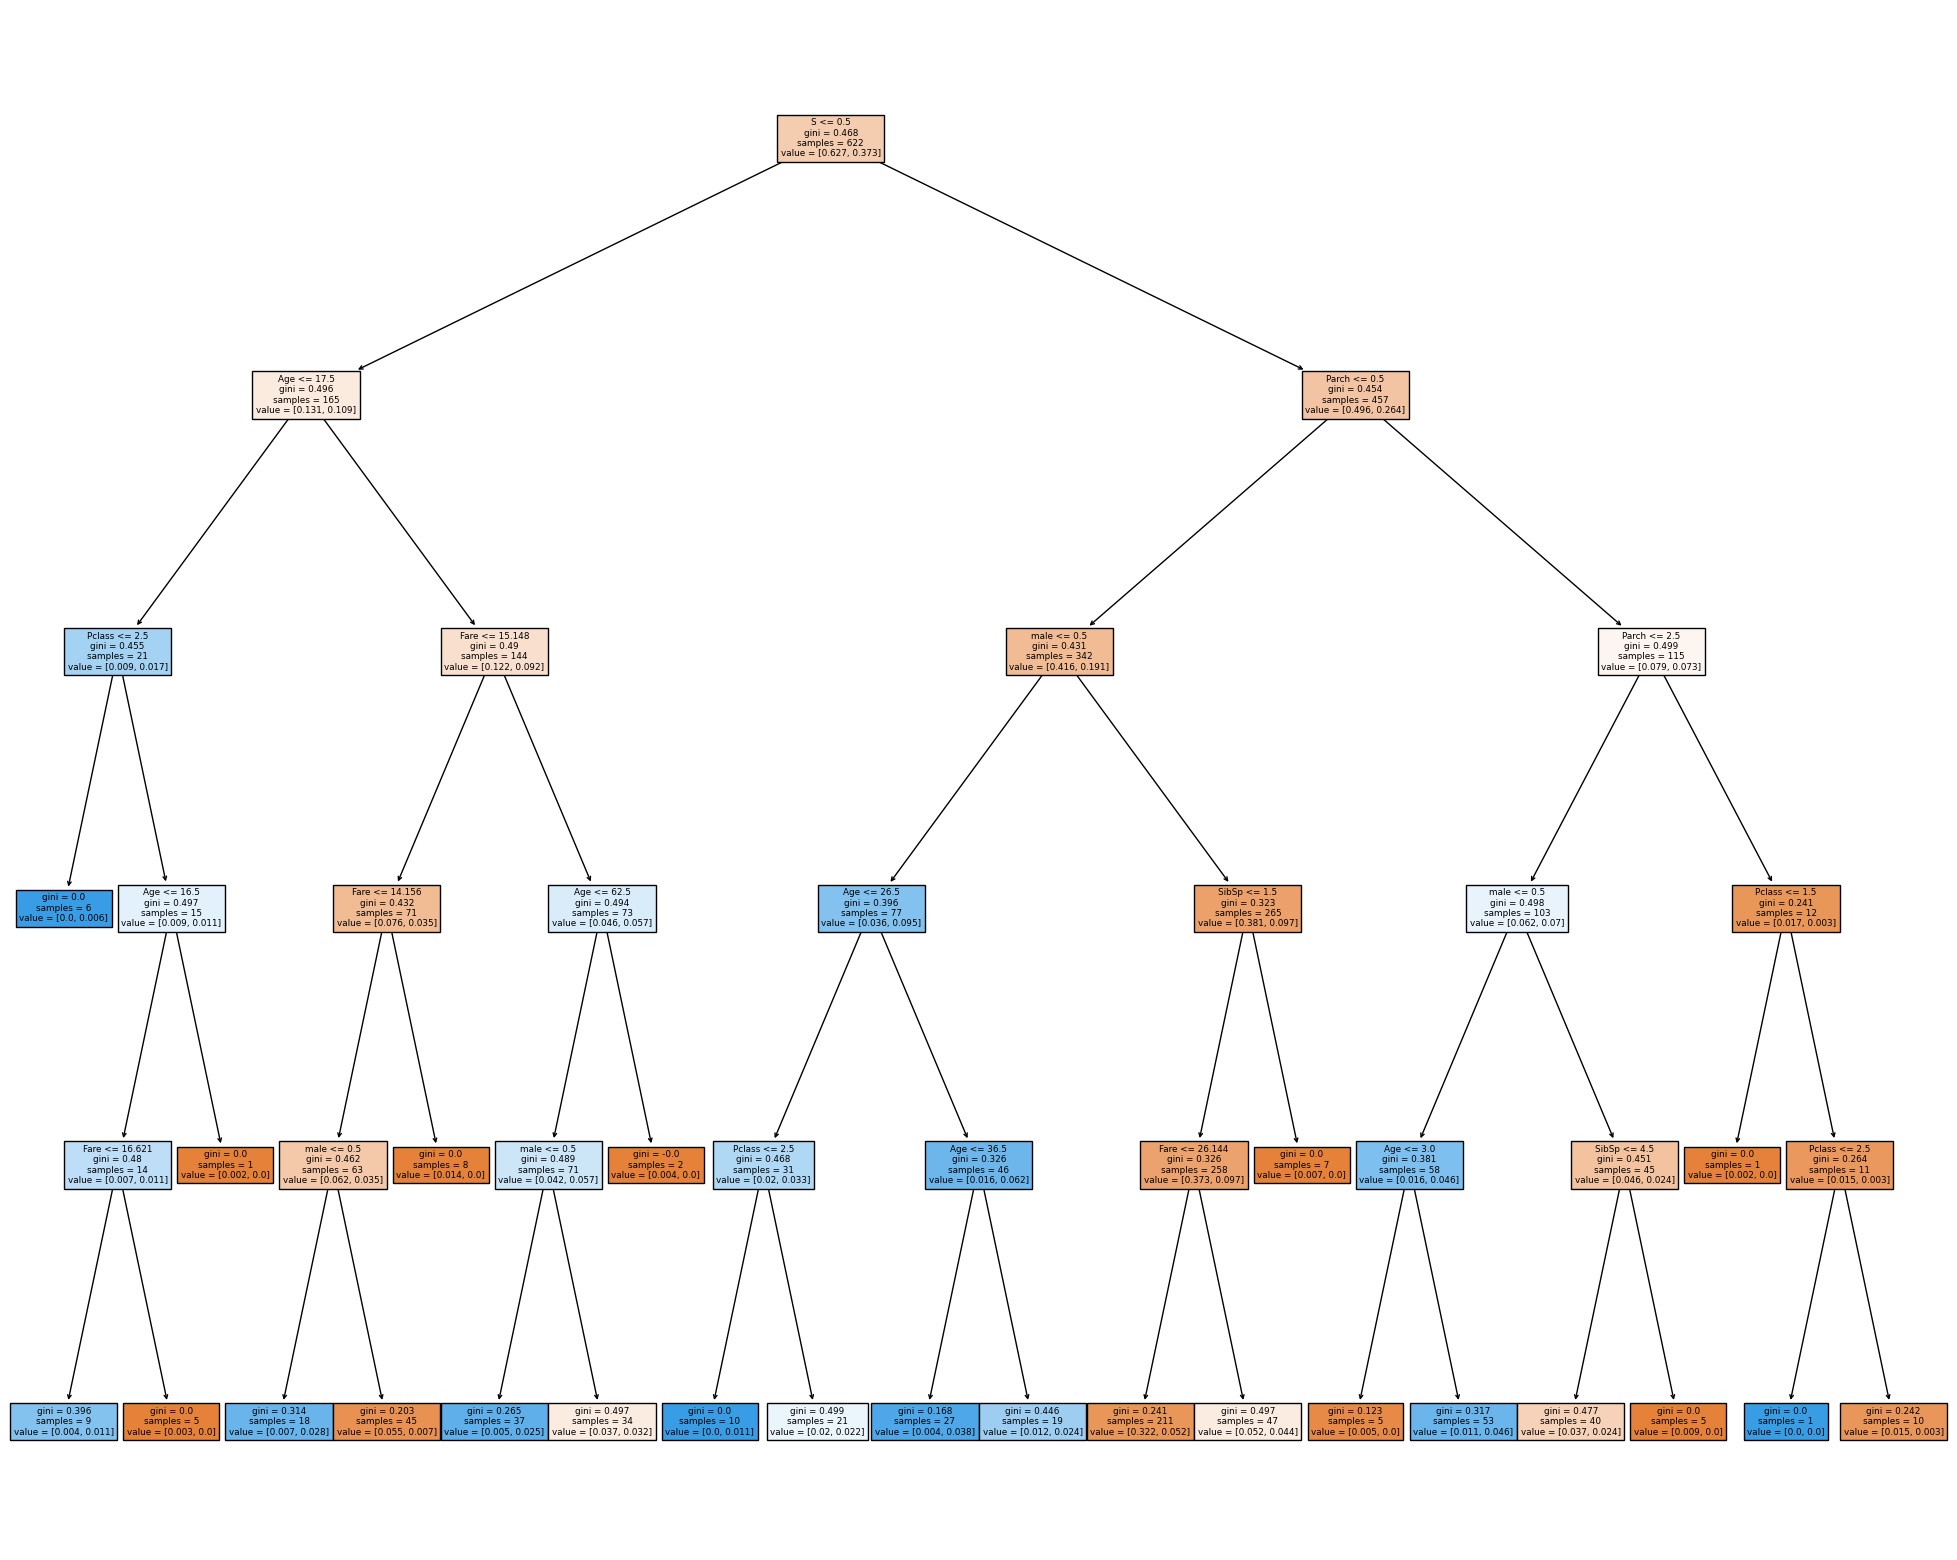

In [75]:
# Visualización del segundo

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_2,feature_names=["Pclass","Age","SibSp","Parch","Fare","male","Q","S"], filled=True)

In [77]:
# Guardamos los dos primerso árbols de random forest

tree_1 = adaboost.estimators_[1]
tree_2 = adaboost.estimators_[2]

[Text(0.5, 0.75, 'male <= 0.5\ngini = 0.475\nsamples = 622\nvalue = [0.613, 0.387]'),
 Text(0.25, 0.25, 'gini = 0.42\nsamples = 214\nvalue = [0.105, 0.244]'),
 Text(0.75, 0.25, 'gini = 0.342\nsamples = 408\nvalue = [0.508, 0.143]')]

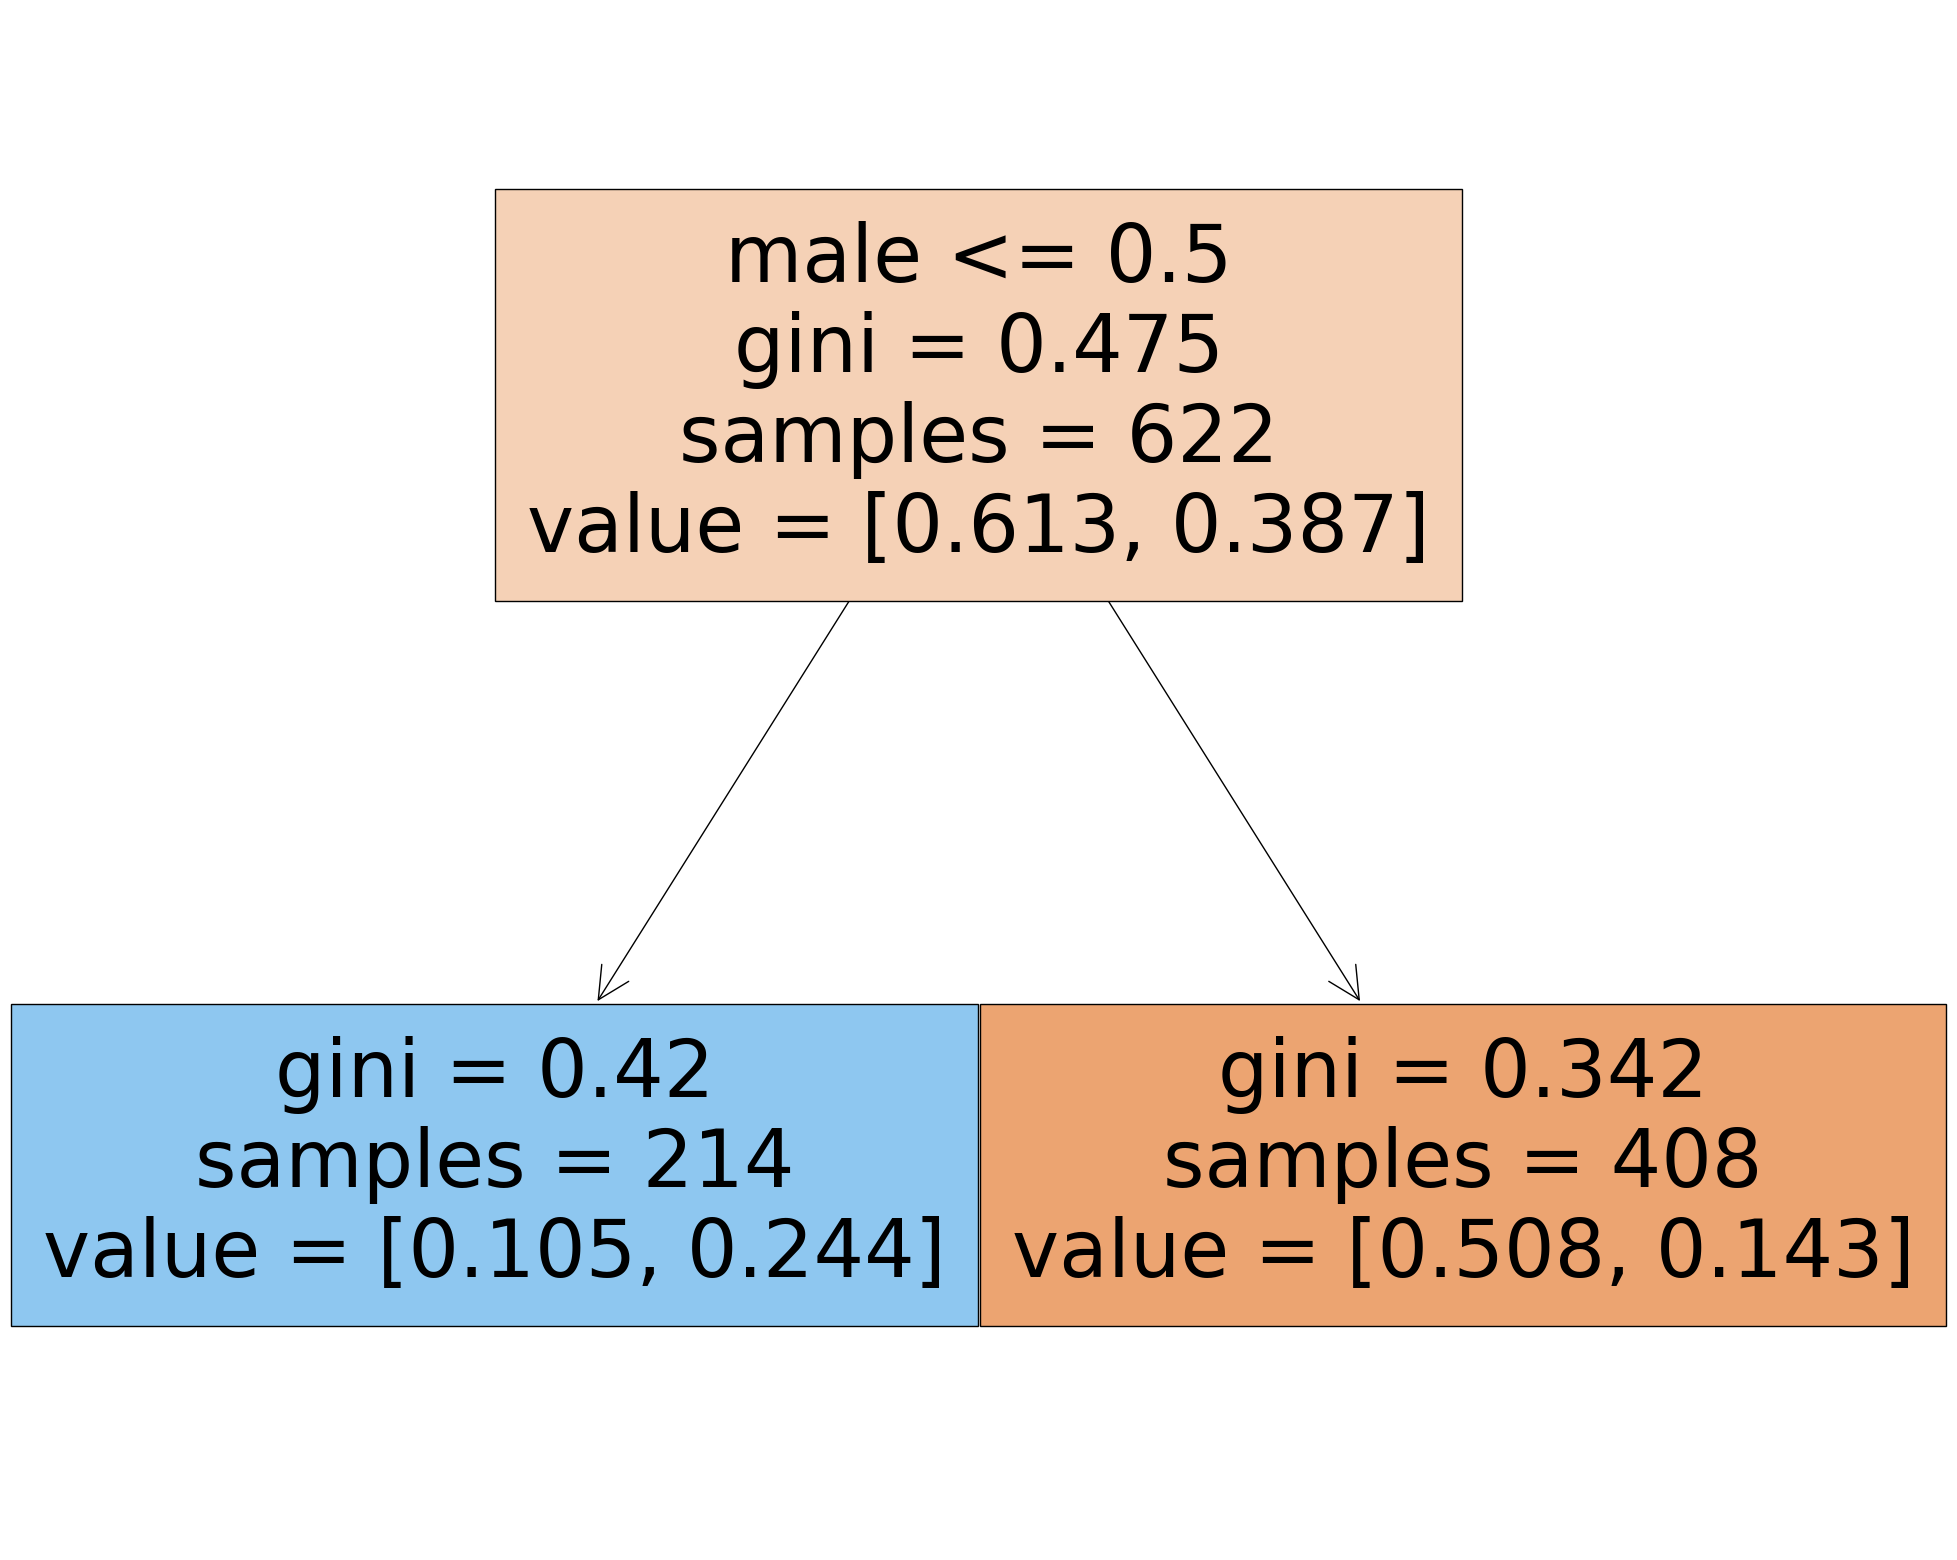

In [79]:
# Visualización del primero

fig = plt.figure(figsize=(25,20))

tree.plot_tree(tree_1,feature_names=["Pclass","Age","SibSp","Parch","Fare","male","Q","S"], filled=True)

[Text(0.5, 0.75, 'male <= 0.5\ngini = 0.479\nsamples = 622\nvalue = [0.603, 0.397]'),
 Text(0.25, 0.25, 'gini = 0.434\nsamples = 214\nvalue = [0.112, 0.241]'),
 Text(0.75, 0.25, 'gini = 0.367\nsamples = 408\nvalue = [0.491, 0.156]')]

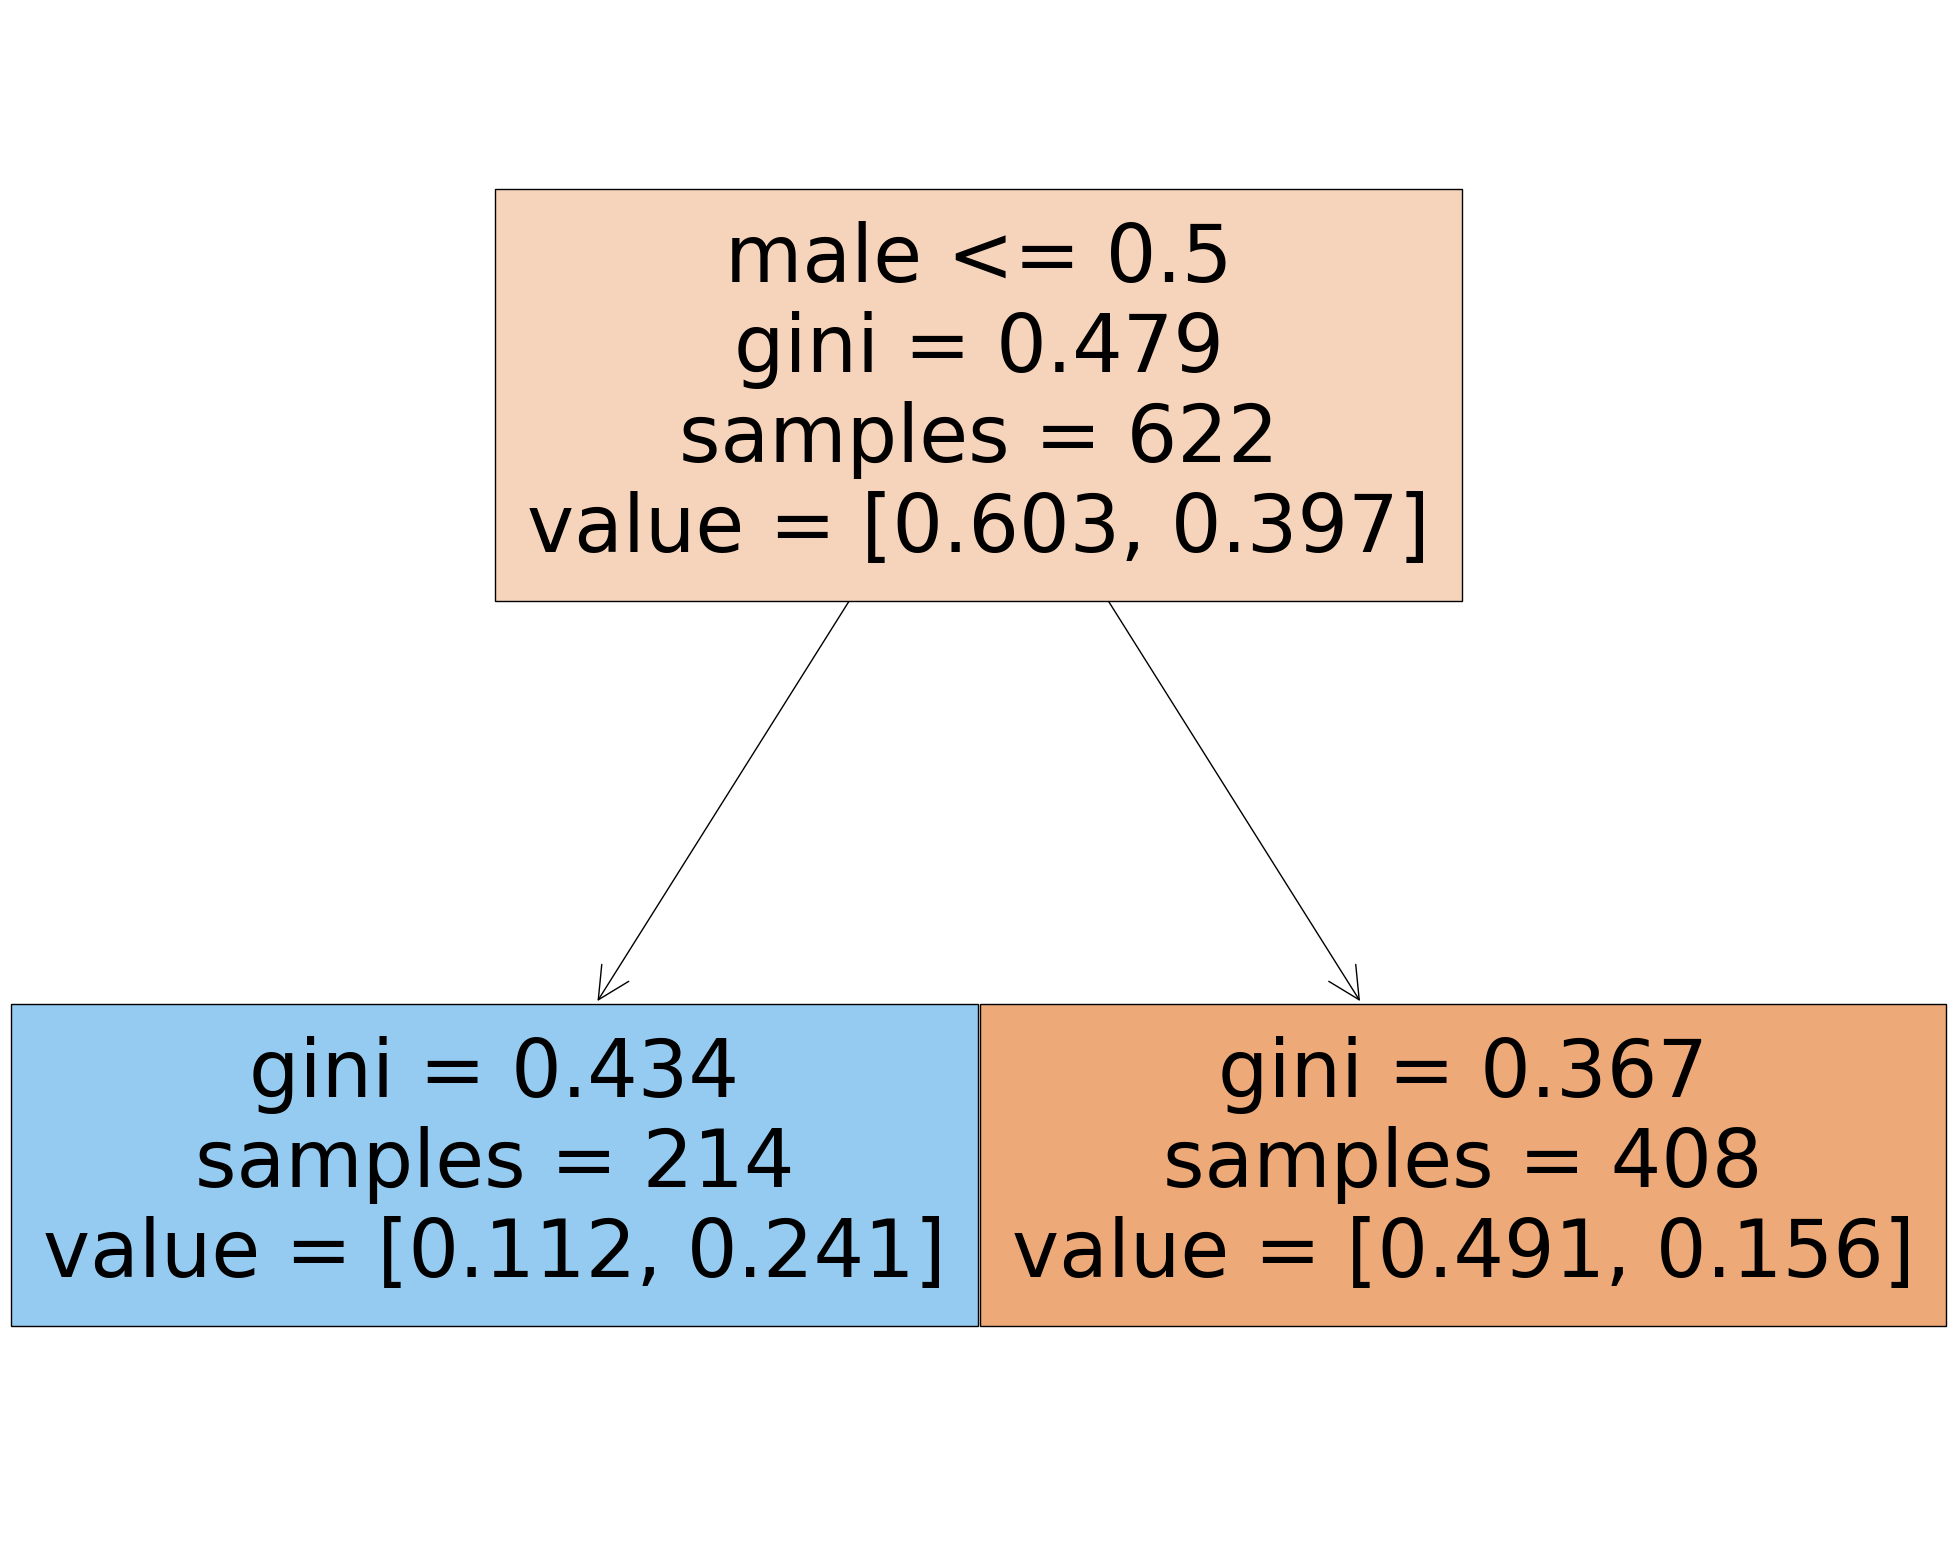

In [81]:
# Visualización del segundo

fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_2,feature_names=["Pclass","Age","SibSp","Parch","Fare","male","Q","S"], filled=True)

In [83]:
# A mayor valor, mayor importancia de la variable en el random forest

adaboost_1.feature_importances_

array([0.04644006, 0.42763498, 0.02713968, 0.02237081, 0.36009531,
       0.07120566, 0.01431401, 0.0307995 ])

#### Evaluación del adaboost

Calculamos la matriz de confusión, algunas métricas de evaluación habituales, y el coeficiente $AUC$ o $ROC$ y el $gini$ para ambos modelos.

<Axes: >

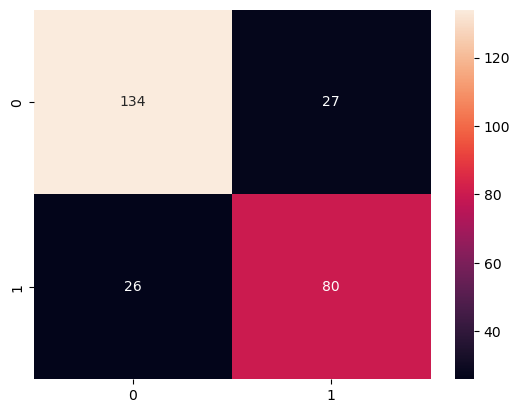

In [86]:
cm = confusion_matrix(y_test, test_prediccion_1)
sns.heatmap(cm,annot=True,fmt="d")

In [90]:
print(classification_report(y_test,test_prediccion_1))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       161
           1       0.75      0.75      0.75       106

    accuracy                           0.80       267
   macro avg       0.79      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267



Para obtener la curva y métrica ROC, volvemos a utilizar las probabilidades estimadas (en lugar de las clases).

In [95]:
fpr_1,tpr_1,umbrales_1=roc_curve(y_test, test_predict_prob_1[:,1], pos_label = 1)

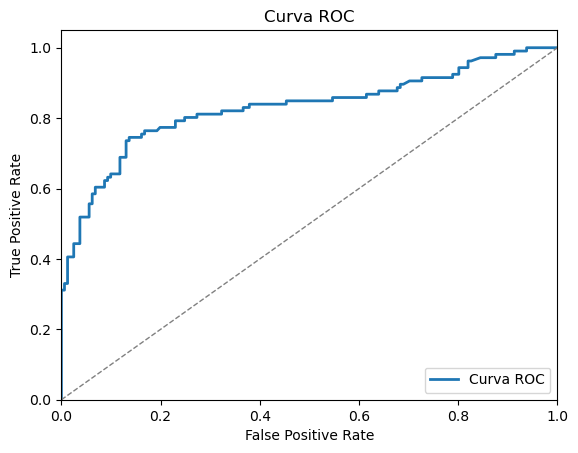

In [97]:
plt.figure()
lw = 2
plt.plot(fpr_1, tpr_1,
         lw=lw, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [99]:
auc_1=auc(fpr_1, tpr_1)
auc_1

0.8301300832063753

In [101]:
roc_1=2*auc_1-1
roc_1

0.6602601664127505

El adaboost tiene un tiene un $AUC=ROC=0.83$ y un gini del 61%, frente al 64% de la regresión logística, 72% del árbol y 75% del random forest. 